In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [4]:
print(tf.__version__)

1.13.1


In [7]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [8]:
print(len(train_data), len(train_labels))

25000 25000


In [11]:
# 단어와 정수 인덱스를 매핑해서 딕셔너리를 가져옵니다.

word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [12]:
# 처음의 몇 개 인덱스는 사전에 정의되어 있습니다.
word_index = {k:(v+3) for k,v in word_index.items()}
word_index['<PAD>']=0
word_index['<START>']=1
word_index['<UNK>']=2
word_index['<UNUSED>']=3

In [13]:
reverse_word_index = dict([(value,key) for (key, value) in word_index.items()])

In [14]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [15]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### 데이터 준비

원-핫 인코딩(one-hot encoding)은 정수 배열을 0과 1로 이루어진 벡터로 변환합니다. 예를 들어 배열 [3, 5]을 인덱스 3과 5만 1이고 나머지는 모두 0인 10,000차원 벡터로 변환할 수 있습니다. 그다음 실수 벡터 데이터를 다룰 수 있는 층-Dense 층-을 신경망의 첫 번째 층으로 사용합니다. 이 방법은 num_words * num_reviews 크기의 행렬이 필요하기 때문에 메모리를 많이 사용합니다.


다른 방법으로는, 정수 배열의 길이가 모두 같도록 패딩(padding)을 추가해 max_length * num_reviews 크기의 정수 텐서를 만듭니다. 이런 형태의 텐서를 다룰 수 있는 임베딩(embedding) 층을 신경망의 첫 번째 층으로 사용할 수 있습니다

In [16]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index['<PAD>'],
                                                      padding='post',
                                                      maxlen=256)

In [18]:
print(len(train_data[0]), len(train_data[1]))

256 256


In [19]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

### 모델 구성

신경망은 층(layer)을 쌓아서 만듭니다. 이 구조에서는 두 가지를 결정해야 합니다:

- 모델에서 얼마나 많은 층을 사용할 것인가?
- 각 층에서 얼마나 많은 은닉 유닛(hidden unit)을 사용할 것인가?
- 이 예제의 입력 데이터는 단어 인덱스의 배열입니다. 예측할 레이블은 0 또는 1입니다. 

In [21]:
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


1. Embedding 층 : 인코딩된 단어를 입력 받고, 단어 인덱스에 해당하는 임베딩 벡터를 찾음. 이 벡터는 모델이 훈련되면서 학습됨. 이 벡터는 출력 배열에 새로운 차원으로 추가됨. 최종 차원은  batch / sequence / embedding

2. GlobalAveragePooling1D 는 sequence 차원에 대해 평균을 계산하여, 각 샘플에 대해 고정된 길이의 출력 벡터를 반환한다. 길이가 다른 입력을 다루는 간단한 방법

3. 이 고정 길이의 출력 벡터는, 16개의 은닉 유닛을 가진 fully connected 층(Dense)를 거친다

4. 마지막 층은 하나의 출력 노드만을 가진 완전 연결층. 시그모이드 활성화 함수를 이용하여 0과 1 사이의 실수를 출력하는데 이는 확률 또는 신뢰도라고 의미

### 은닉 유닛

위 모델에는 입력과 출력 사이에 두 개의 중간 또는 "은닉" 층이 있습니다. 출력(유닛 또는 노드, 뉴런)의 개수는 층이 가진 표현 공간(representational space)의 차원이 됩니다. 다른 말로 하면, 내부 표현을 학습할 때 허용되는 네트워크 자유도의 양입니다.

모델에 많은 은닉 유닛(고차원의 표현 공간)과 층이 있다면 네트워크는 더 복잡한 표현을 학습할 수 있습니다. 하지만 네트워크의 계산 비용이 많이 들고 원치않는 패턴을 학습할 수도 있습니다. 이런 표현은 훈련 데이터의 성능을 향상시키지만 테스트 데이터에서는 그렇지 못합니다. 이를 과대적합(overfitting)이라고 부릅니다.

### 손실 함수와 옵티마이저

모델이 훈련하려면 손실 함수(loss function)과 옵티마이저(optimizer)가 필요합니다. 이 예제는 이진 분류 문제이고 모델이 확률을 출력하므로(출력층의 유닛이 하나이고 sigmoid 활성화 함수를 사용합니다), binary_crossentropy 손실 함수를 사용하겠습니다.

다른 손실 함수를 선택할 수 없는 것은 아닙니다. 예를 들어 mean_squared_error를 선택할 수 있습니다. 하지만 일반적으로 binary_crossentropy가 확률을 다루는데 적합합니다. 이 함수는 확률 분포 간의 거리를 측정합니다. 여기에서는 정답인 타깃 분포와 예측 분포 사이의 거리입니다.

In [22]:
model.compile(optimizer=tf.train.AdamOptimizer(),
             loss = 'binary_crossentropy',
             metrics = ['acc'])

### 검증 세트 만들기

In [23]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### 모델 훈련

512개의 샘플로 이루어진 미니배치(mini-batch)에서 40번의 에포크(epoch) 동안 훈련합니다. x_train과 y_train 텐서에 있는 모든 샘플에 대해 40번 반복한다는 뜻입니다. 훈련하는 동안 10,000개의 검증 세트에서 모델의 손실과 정확도를 모니터링

In [24]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 40,
                   batch_size=512,
                   validation_data = (x_val, y_val),
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 1s 43us/sample - loss: 0.6919 - acc: 0.5971 - val_loss: 0.6898 - val_acc: 0.6889
Epoch 2/40
15000/15000 [==============================] - 0s 27us/sample - loss: 0.6860 - acc: 0.7323 - val_loss: 0.6822 - val_acc: 0.7430
Epoch 3/40
15000/15000 [==============================] - 0s 29us/sample - loss: 0.6740 - acc: 0.7616 - val_loss: 0.6670 - val_acc: 0.7642
Epoch 4/40
15000/15000 [==============================] - 0s 26us/sample - loss: 0.6523 - acc: 0.7735 - val_loss: 0.6416 - val_acc: 0.7677
Epoch 5/40
15000/15000 [==============================] - 0s 28us/sample - loss: 0.6184 - acc: 0.7991 - val_loss: 0.6050 - val_acc: 0.7903
Epoch 6/40
15000/15000 [==============================] - 0s 25us/sample - loss: 0.5734 - acc: 0.8185 - val_loss: 0.5616 - val_acc: 0.8061
Epoch 7/40
15000/15000 [==============================] - 0s 30us/sa

In [25]:
results = model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 1s 20us/sample - loss: 0.3370 - acc: 0.8705


### 정확도와 손실 그래프

model.fit()은 history 객체애 훈련 중의 모든 정보가 담긴 딕셔너리가 들어있다.

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [29]:
%matplotlib inline

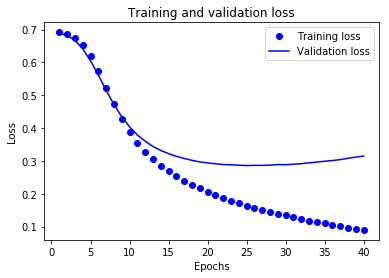

In [30]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

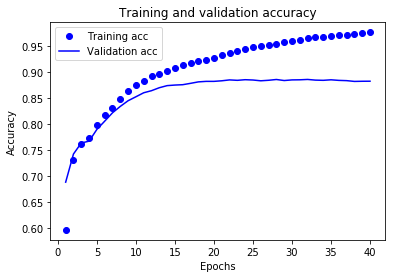

In [31]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()